# Required Library

In [22]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image

# Prepare Dataset

In [23]:

# Paths
DATA_DIR    = r'C:\Users\ASUS ZENBOOK\Desktop\Dataset 2'
TRAIN_DIR   = os.path.join(DATA_DIR, 'train')
VAL_DIR     = os.path.join(DATA_DIR, 'validation')
TEST_DIR    = os.path.join(DATA_DIR, 'Test')

# Image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Automatically detect the number of classes
class_names = os.listdir(TRAIN_DIR)  # Assuming classes are in the train directory
num_classes = len(class_names)

# Print detected classes vertically
print(f"Detected {num_classes} classes:")
for class_name in class_names:
    print(f"- {class_name}")

# Define the preprocess_image function
def preprocess_image(image):
    # Ensure the image is in the correct format
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    
    # Convert numpy array to PIL Image
    image = Image.fromarray(image)
    
    if image.mode == 'P':  # If the image is in palette mode
        image = image.convert('RGBA')
    
    # Convert back to numpy array and ensure it's in float32 format
    return np.array(image).astype(np.float32)

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_image
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    preprocessing_function=preprocess_image
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    preprocessing_function=preprocess_image
)

# Load datasets
train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Save class indices
with open("class_indices.json", "w") as f:
    json.dump(train_data.class_indices, f)

# Ensure test data uses the same class indices
test_data.class_indices = train_data.class_indices

Detected 15 classes:
- Burger
- Cheese Cookies
- Egg
- Fried Chicken
- Fried Noodles
- Fried Rice
- Fries
- Hot Dog
- Klepon
- Lumpur Cake
- Pizza
- Rawon
- Sandwich
- Satay
- Sweet Coconut Pancake
Found 11251 images belonging to 15 classes.
Found 2257 images belonging to 15 classes.
Found 1615 images belonging to 15 classes.


#  Build & Train Model

In [24]:
# Define the build_model function
def build_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True  # Unfreeze the base model layers for fine-tuning

    # Fine-tune some layers
    for layer in base_model.layers[:-20]:  # Freeze all but the last 20 layers
        layer.trainable = False

    # Add custom layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')  # Output layer
    ])
    return model

# Custom callback to log learning rate
class LearningRateLogger(Callback):
    def __init__(self):
        super(LearningRateLogger, self).__init__()
        self.learning_rates = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy()
        self.learning_rates.append(lr)
        logs = logs or {}
        logs['learning_rate'] = lr

# Build model
model = build_model(num_classes=num_classes)

# Compile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Adjusted learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Initialize the logger
lr_logger = LearningRateLogger()

# Callbacks
checkpoint = ModelCheckpoint(
    filepath='best_model2.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop training if validation loss doesn't improve for 5 epochs
    restore_best_weights=True
)

# Train the model with reduced epochs
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,  # Reduced number of epochs
    callbacks=[checkpoint, early_stopping, lr_logger]  # Added early stopping
)

# Save the model
model.save('final_model3.h5')

Epoch 1/15
197/352 ━━━━━━━━━━━━━━━━━━━━ 4:29 2s/step - accuracy: 0.1486 - loss: 2.4675

c:\Users\ASUS ZENBOOK\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


352/352 ━━━━━━━━━━━━━━━━━━━━ 647s 2s/step - accuracy: 0.1675 - loss: 2.4071 - val_accuracy: 0.1781 - val_loss: 2.7548 - learning_rate: 1.0000e-04
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.2337 - loss: 2.1771 - val_accuracy: 0.2056 - val_loss: 2.6658 - learning_rate: 1.0000e-04
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 286s 811ms/step - accuracy: 0.2687 - loss: 2.0942 - val_accuracy: 0.1595 - val_loss: 2.7583 - learning_rate: 1.0000e-04
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 236s 665ms/step - accuracy: 0.2802 - loss: 2.0716 - val_accuracy: 0.2096 - val_loss: 2.5921 - learning_rate: 1.0000e-04
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 262s 746ms/step - accuracy: 0.2973 - loss: 2.0400 - val_accuracy: 0.1599 - val_loss: 2.8903 - learning_rate: 1.0000e-04
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 299s 849ms/step - accuracy: 0.3003 - loss: 2.0141 - val_accuracy: 0.1719 - val_loss: 2.9010 - learning_rate: 1.0000e-04
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 348s 986ms/step -

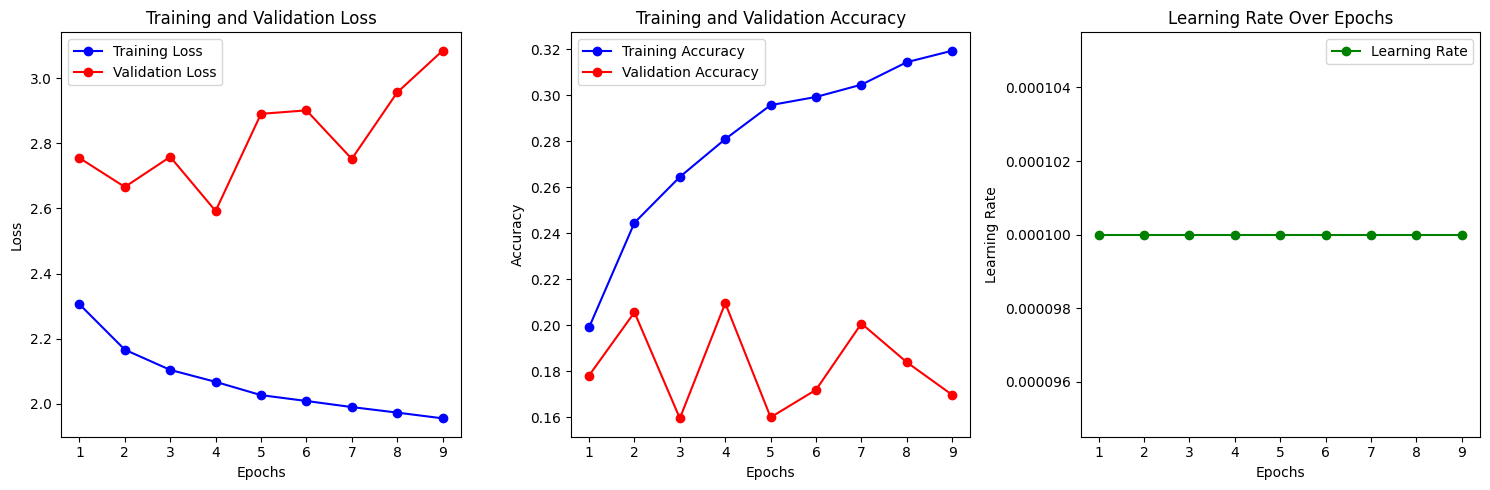

In [25]:
# Plotting
epochs = range(1, len(lr_logger.learning_rates) + 1)

# Loss Plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, history.history['loss'][:len(epochs)], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'][:len(epochs)], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(epochs, history.history['accuracy'][:len(epochs)], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'][:len(epochs)], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Learning Rate Plot
plt.subplot(1, 3, 3)
plt.plot(epochs, lr_logger.learning_rates, 'go-', label='Learning Rate')
plt.title('Learning Rate Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate Model

In [31]:
# Load the trained model
model = load_model("final_model3.h5")  # Use the model you want to evaluate

# Set up the test data generator (make sure you have the test images available)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
   r'C:\Users\ASUS ZENBOOK\Desktop\Dataset 2\validation',  # Replace with the correct path to your test data
    target_size=(224, 224),  # Image size used for model training
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 2257 images belonging to 15 classes.
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 222ms/step - accuracy: 0.1765 - loss: 2.6964
Test Accuracy: 18.30%


# Saved Model

In [33]:
# Create the directory if it doesn't exist
os.makedirs('saved_model', exist_ok=True)

# Load the trained model
model = load_model("final_model3.h5")  # Use the final model for saving

# Save the model in the SavedModel format
model.save('saved_model/FIT.h5')

# APP

In [34]:
import streamlit as st
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

In [36]:
# Load the trained model
model = load_model("final_model3.h5")  # Use the best or final model

# Class labels (as an example, you should modify this to match your dataset)
class_labels = [
    "Burger", "Cheese Cookies", "Egg", "Fried Chicken", "Fried Noodles", "Fried Rice", "Fries", "Hot Dog", "Klepon", 
    "Lumpur Cake", "Pizza", "Rawon", "Sandwich", "Satay", "Sweet Coconut Pancake"
    
    #"Baked Potato", "Burger", "Crispy Chicken", "Donut", "Fries", 
    #"Hot Dog", "PIzza", "Sandwich", "Taco", "Taquito"
]

# Function to preprocess the uploaded image
def preprocess_image(image):
    image = image.resize((224, 224))  # Resize for model input
    image_array = np.array(image)
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    image_array = image_array / 255.0  # Normalize
    return image_array


# Streamlit app
st.title("FIT App")
uploaded_file = st.file_uploader("Upload a food image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Predict
    st.write("Classifying...")
    processed_image = preprocess_image(image)
    predictions = model.predict(processed_image)
    predicted_class_index = np.argmax(predictions)

    # Map the predicted class index to the corresponding label
    predicted_class_label = class_labels[predicted_class_index]
    
    # Display the predicted class
    st.write(f"Predicted Class: {predicted_class_label}")


2024-12-19 10:02:26.631 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-19 10:02:27.013 
  command:

    streamlit run C:\Users\ASUS ZENBOOK\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
2024-12-19 10:02:27.014 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-19 10:02:27.016 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-19 10:02:27.017 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-19 10:02:27.017 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-19 10:02:27.018 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-19 10:02:27.0